## Data haqida ma'lumotlar

Bu indekslardan, ushbu dataset **o‘simliklarning gulchanglanishi va hosildorligi** bilan bog‘liq ma'lumotlarni o‘z ichiga oladi. Ayniqsa, **turli hasharotlar** (masalan, asalari, bumblebees, andrena, osmia) orqali changlanish jarayoni va hosilning boshqa o‘zgaruvchilarga bog‘liqligi o‘rganilgan ko‘rinadi. Ba’zi ustunlarning ma'nosi quyidagicha:

- **clonesize**: o‘simlik klonining o‘lchami.
- **honeybee, bumbles, andrena, osmia**: turli hasharot turlari soni yoki ko‘rish darajasi.
- **MaxOfUpperTRange, MinOfUpperTRange, AverageOfUpperTRange**: yuqori harorat oralig‘i (maksimal, minimal va o‘rtacha).
- **MaxOfLowerTRange, MinOfLowerTRange, AverageOfLowerTRange**: past harorat oralig‘i.
- **RainingDays, AverageRainingDays**: yomg‘irli kunlar soni va ularning o‘rtacha ko‘rsatkichi.
- **fruitset, fruitmass, seeds, yield**: hosil bilan bog‘liq o‘zgaruvchilar (meva shakllanishi, meva massasi, urug‘lar soni, umumiy hosil).

Bu dataset asosan o‘simliklarning hosildorligiga ta’sir etuvchi omillarni, ayniqsa changlanish va iqlim omillari bilan bog‘liq ma'lumotlarni tahlil qilish uchun mo‘ljallangan.

## Ustunlar
1. **id**: Har bir kuzatish uchun noyob identifikator.
2. **Row#**: Jadvaldagi qatordan tartib raqami (odatda har bir kuzatish uchun ishlatiladi).
3. **clonesize**: O‘simlik klonining o‘lchami, ya’ni o‘simlik guruhidagi nusxalarning hajmi. Bu hosildorlik va boshqa o‘zgaruvchilar bilan bog‘liq bo‘lishi mumkin.
4. **honeybee**: Changlanishda qatnashgan asalari soni yoki ularning changlanish jarayonidagi faollik darajasi.
5. **bumbles**: Changlanishda qatnashgan bumblebees (yirik asalarilar) soni yoki faolligi.
6. **andrena**: Andrena turiga mansub yovvoyi asalarilar soni yoki faolligi (changlatuvchi sifatida qanchalik faol ekani).
7. **osmia**: Osmia turiga kiruvchi asalarilar (ko‘pincha mayda yovvoyi asalarilar) soni yoki changlanishdagi faolligi.
8. **MaxOfUpperTRange**: Kuzatish davridagi yuqori harorat oralig‘idagi maksimal harorat.
9. **MinOfUpperTRange**: Yuqori harorat oralig‘idagi minimal harorat.
10. **AverageOfUpperTRange**: Yuqori harorat oralig‘ining o‘rtacha qiymati.
11. **MaxOfLowerTRange**: Past harorat oralig‘idagi maksimal harorat.
12. **MinOfLowerTRange**: Past harorat oralig‘idagi minimal harorat.
13. **AverageOfLowerTRange**: Past harorat oralig‘ining o‘rtacha qiymati.
14. **RainingDays**: Kuzatish davridagi yomg‘irli kunlar soni.
15. **AverageRainingDays**: Yomg‘irli kunlarning o‘rtacha qiymati (ma'lum bir davr mobaynida).
16. **fruitset**: Meva shakllanish darajasi, ya’ni o‘simliklarda qanchalik meva hosil bo‘lganligi (foiz yoki son).
17. **fruitmass**: Mevaning o‘rtacha massasi yoki hajmi.
18. **seeds**: Meva ichidagi urug‘lar soni, bu ko‘pincha hosilning sifatini va hajmini aniqlashga yordam beradi.
19. **yield**: Hosilning umumiy hajmi yoki og‘irligi, o‘lchov birligi hududga qarab (masalan, gektar) o‘zgarishi mumkin.


In [ ]:
import pandas as pd
import optuna
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import lime
import lime.lime_tabular



## Train data

In [22]:
train_df=pd.read_csv('train.csv')
train_df=train_df.drop(columns=['id', 'Row#'])
train_df.head(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,12.5,0.25,0.25,0.25,0.75,69.7,42.1,58.2,50.2,24.3,41.2,16.00,0.26,0.477941,0.423927,34.043022,6079.08526
1,25.0,0.00,0.00,0.00,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.334594,0.354415,27.735098,2946.92602
2,25.0,0.50,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.468192,0.417915,34.838815,5323.30034


## Test data

In [23]:
test_df=pd.read_csv('test.csv')
test_df=test_df.drop(columns=['id', 'Row#'])
test_df.head(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,12.5,0.25,0.38,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,34.0,0.56,0.459088,0.408610,33.289052
1,25.0,0.50,0.38,0.38,0.50,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.535895,0.442529,36.957873
2,25.0,0.50,0.25,0.63,0.75,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.421449,0.401068,32.417872


## Describe the train data

In [24]:
train_df.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,19.773500,0.388500,0.284573,0.486751,0.591612,82.245667,49.719033,68.717353,59.282947,28.686927,48.611360,18.804700,0.327261,0.501015,0.445967,36.115335,6022.687345
std,6.644451,0.390162,0.058855,0.147560,0.144194,9.104125,5.519865,7.606632,6.579928,3.180584,5.371006,11.880294,0.166934,0.077379,0.038092,4.121393,1362.796312
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,56.800000,50.200000,24.300000,30.000000,1.000000,0.060000,0.029066,0.217545,22.079199,1637.704020
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.451083,0.418220,33.239806,5124.854900
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506225,0.446518,36.040675,6107.382470
75%,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.564795,0.472271,39.099614,7028.673500
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,62.000000,34.000000,0.560000,0.960586,0.645475,46.369344,8969.401840


## Split data to X and y

X - feature data, 
y - target data

In [25]:
X = train_df.drop(columns=['yield'])  
y = train_df['yield'] 

## Number of outliers per feature

In [26]:
Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((train_df < (Q1 - 1.5 * IQR)) | (train_df > (Q3 + 1.5 * IQR)))
outliers_per_feature = outliers.sum()
print("Number of outliers per feature:\n", outliers_per_feature)

Number of outliers per feature:
 clonesize                  0
honeybee                   8
bumbles                   12
andrena                    8
osmia                     50
MaxOfUpperTRange           0
MinOfUpperTRange           0
AverageOfUpperTRange       0
MaxOfLowerTRange           0
MinOfLowerTRange           0
AverageOfLowerTRange       4
RainingDays             3614
AverageRainingDays        51
fruitset                  90
fruitmass                 36
seeds                      8
yield                     30
dtype: int64


In [27]:
train_df.corr().style.background_gradient()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
clonesize,1.000000,0.281753,0.067231,0.024998,-0.063095,0.014498,0.014312,0.014414,0.014497,0.014524,0.014488,0.180171,0.183720,-0.430690,-0.395877,-0.413282,-0.414196
honeybee,0.281753,1.000000,-0.032568,0.021704,-0.024215,0.004320,0.004257,0.004332,0.004324,0.004329,0.004151,0.041167,0.030145,-0.109703,-0.103309,-0.110824,-0.107869
bumbles,0.067231,-0.032568,1.000000,-0.123922,0.174074,-0.010827,-0.010498,-0.010341,-0.010648,-0.010537,-0.010029,-0.084582,-0.081813,0.173703,0.174824,0.180868,0.177281
andrena,0.024998,0.021704,-0.123922,1.000000,0.341832,-0.009516,-0.009735,-0.009959,-0.009926,-0.009756,-0.010254,-0.041906,-0.043045,0.129153,0.111332,0.112469,0.122463
osmia,-0.063095,-0.024215,0.174074,0.341832,1.000000,-0.011543,-0.011632,-0.011405,-0.011527,-0.011476,-0.011951,-0.095874,-0.095683,0.278504,0.256177,0.258819,0.271989
MaxOfUpperTRange,0.014498,0.004320,-0.010827,-0.009516,-0.011543,1.000000,0.999475,0.999327,0.999657,0.999738,0.998303,-0.001452,-0.002587,0.026773,0.149095,0.066244,-0.004252
MinOfUpperTRange,0.014312,0.004257,-0.010498,-0.009735,-0.011632,0.999475,1.000000,0.999438,0.999538,0.999811,0.998444,-0.001652,-0.002748,0.027175,0.149828,0.066773,-0.004008
AverageOfUpperTRange,0.014414,0.004332,-0.010341,-0.009959,-0.011405,0.999327,0.999438,1.000000,0.999456,0.999601,0.998186,-0.001906,-0.003018,0.027631,0.150538,0.067310,-0.003666
MaxOfLowerTRange,0.014497,0.004324,-0.010648,-0.009926,-0.011527,0.999657,0.999538,0.999456,1.000000,0.999868,0.998422,-0.001528,-0.002633,0.027062,0.149717,0.066613,-0.004082
MinOfLowerTRange,0.014524,0.004329,-0.010537,-0.009756,-0.011476,0.999738,0.999811,0.999601,0.999868,1.000000,0.998584,-0.001623,-0.002722,0.026995,0.149552,0.066534,-0.004109


## the outliers to every column in boxplots

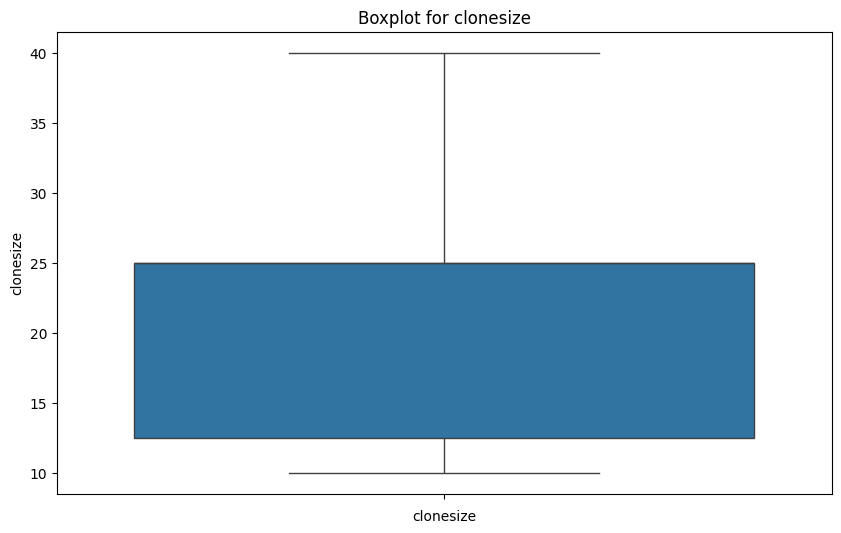

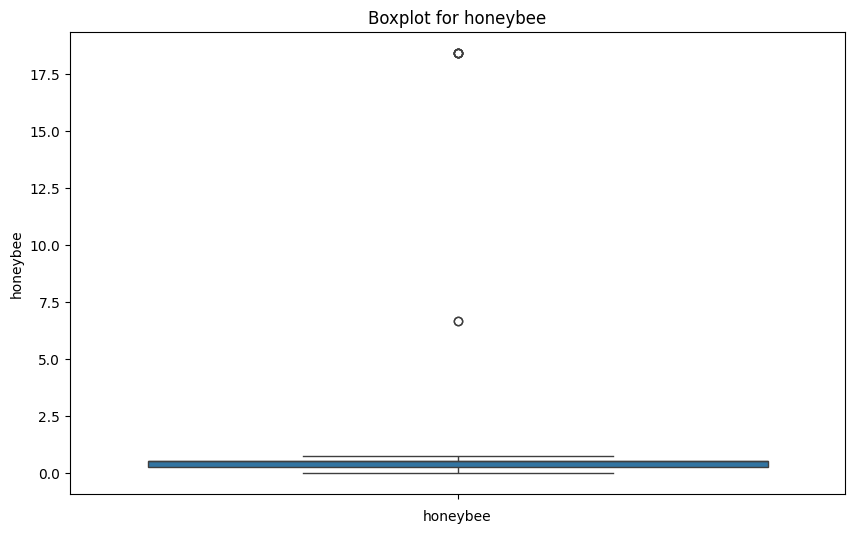

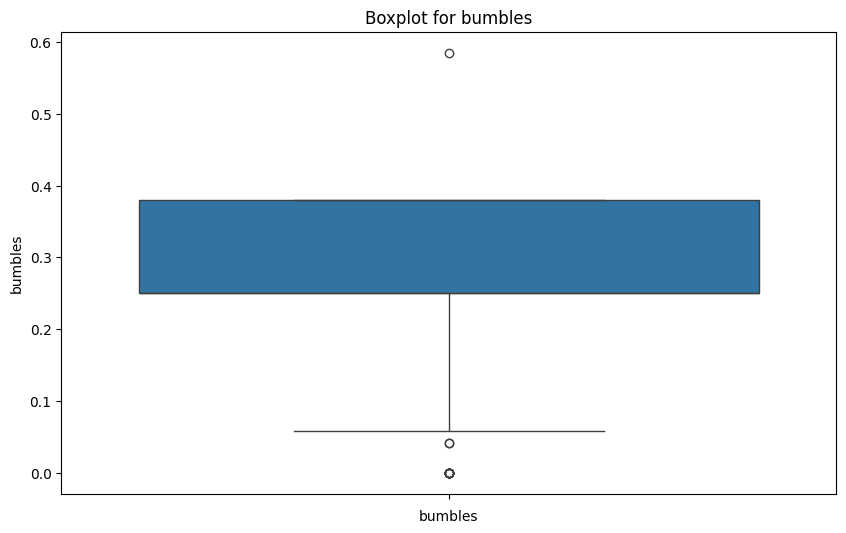

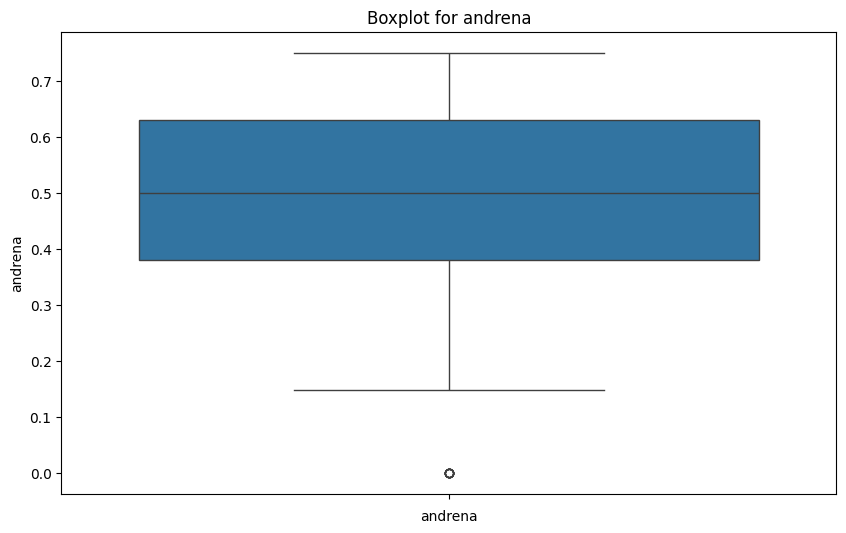

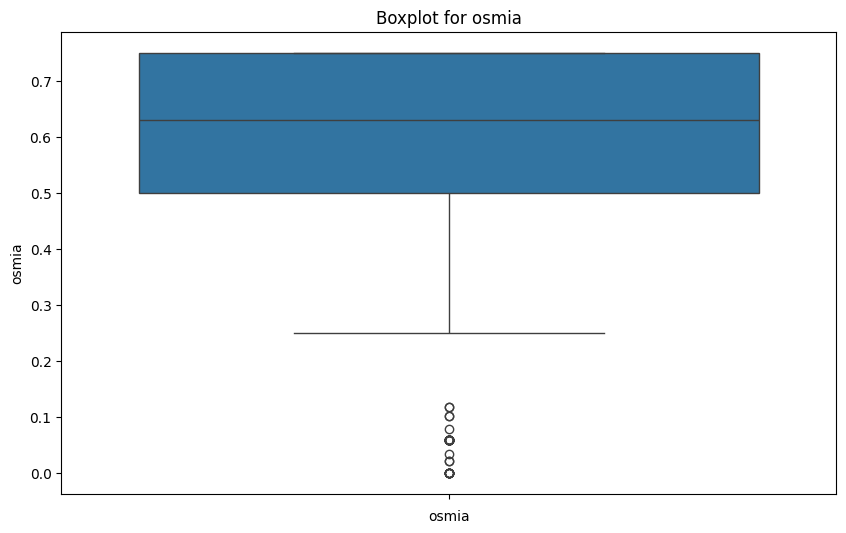

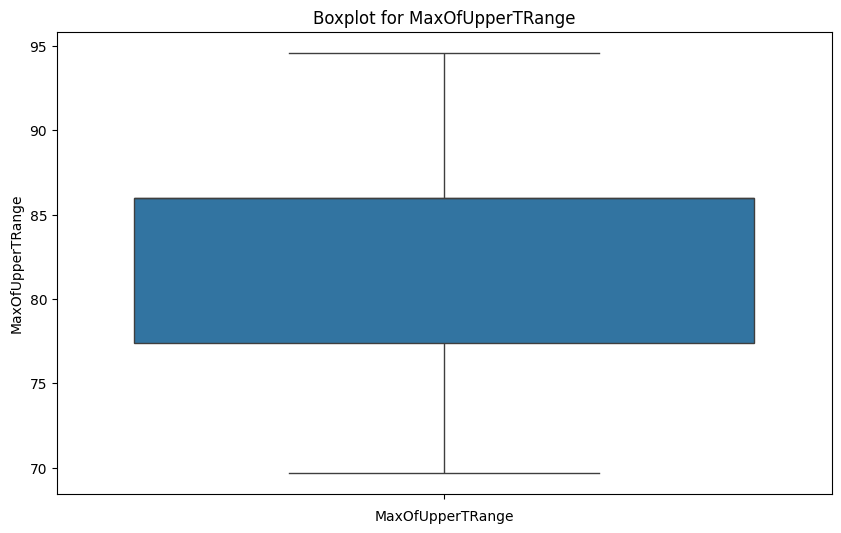

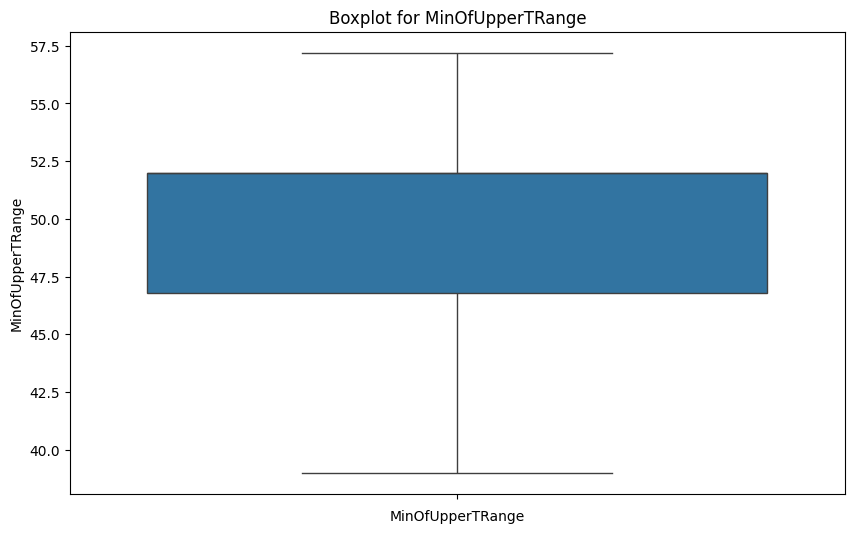

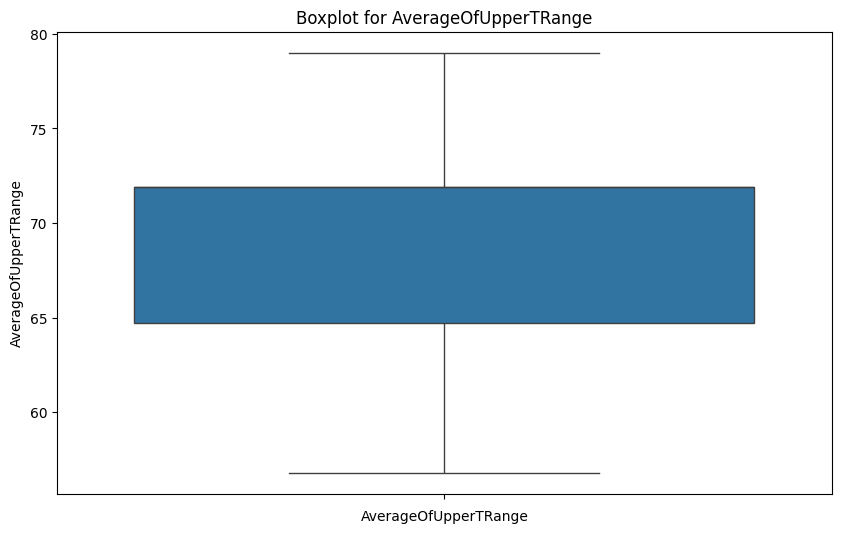

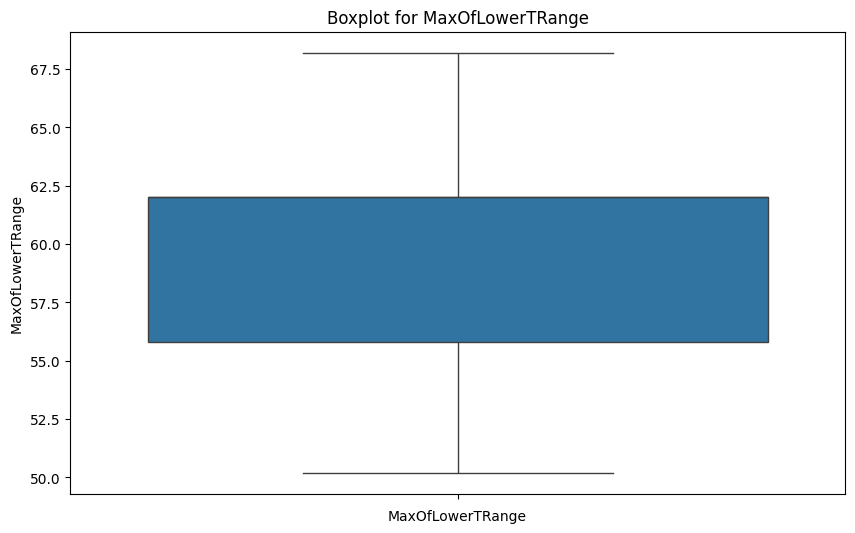

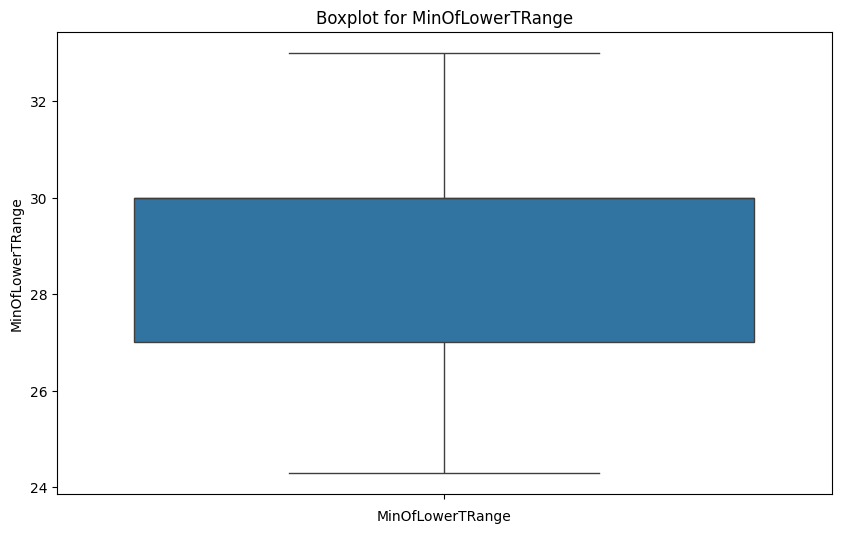

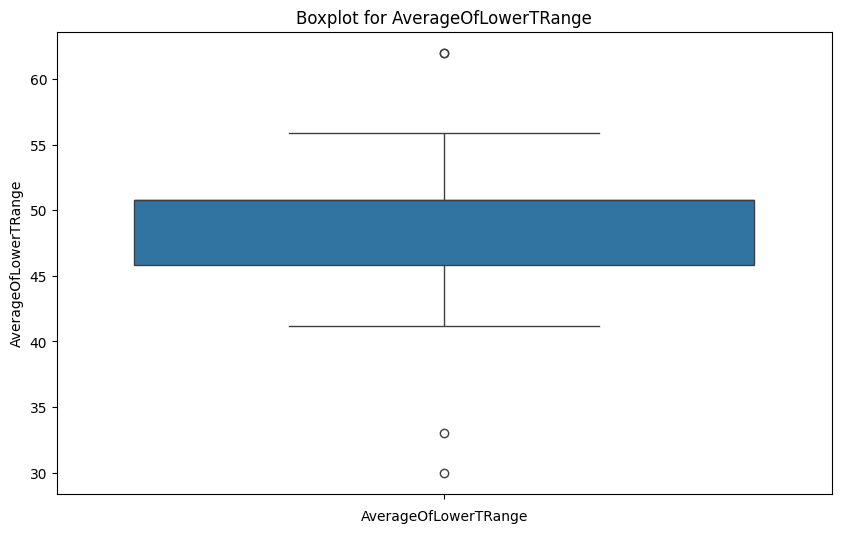

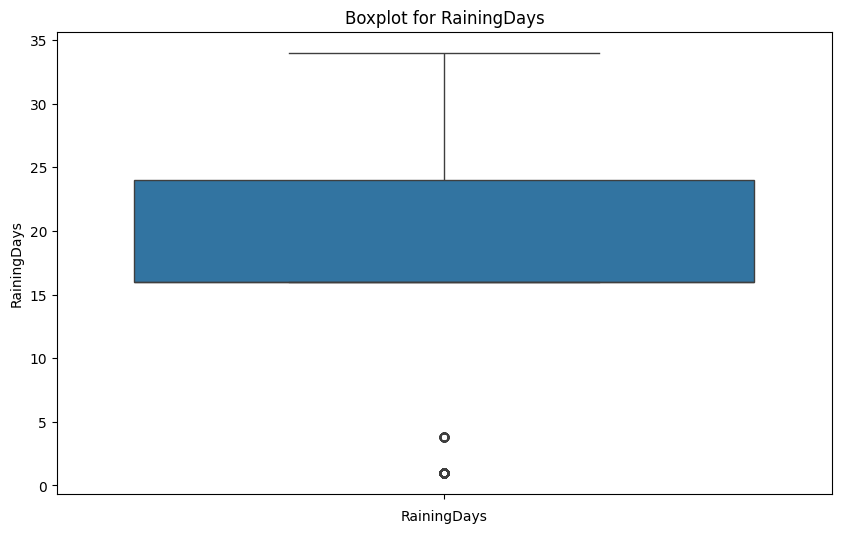

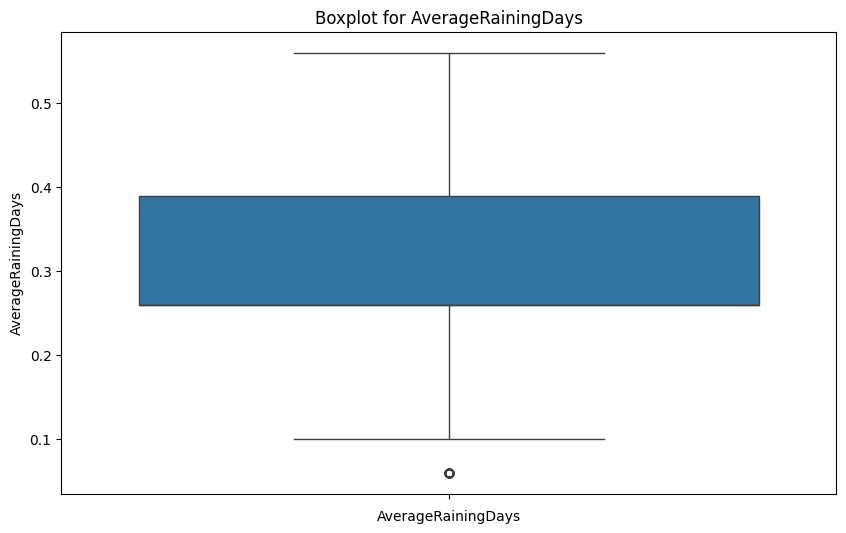

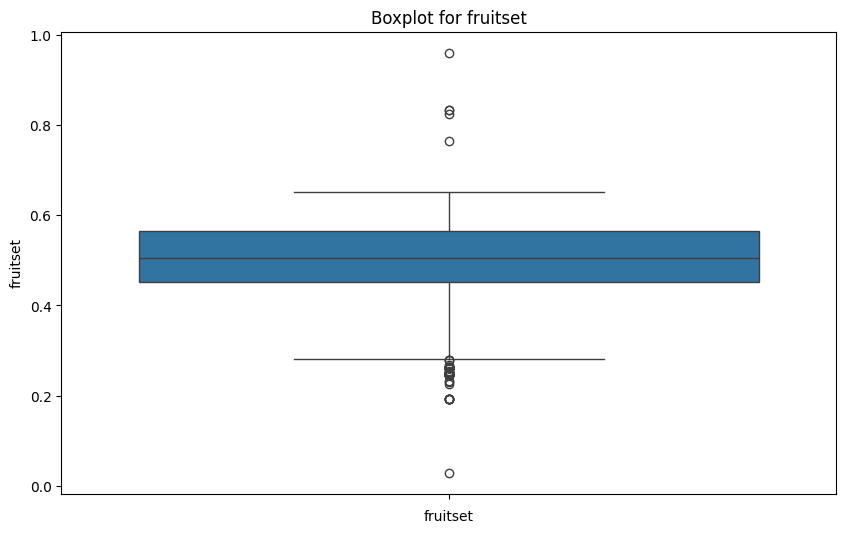

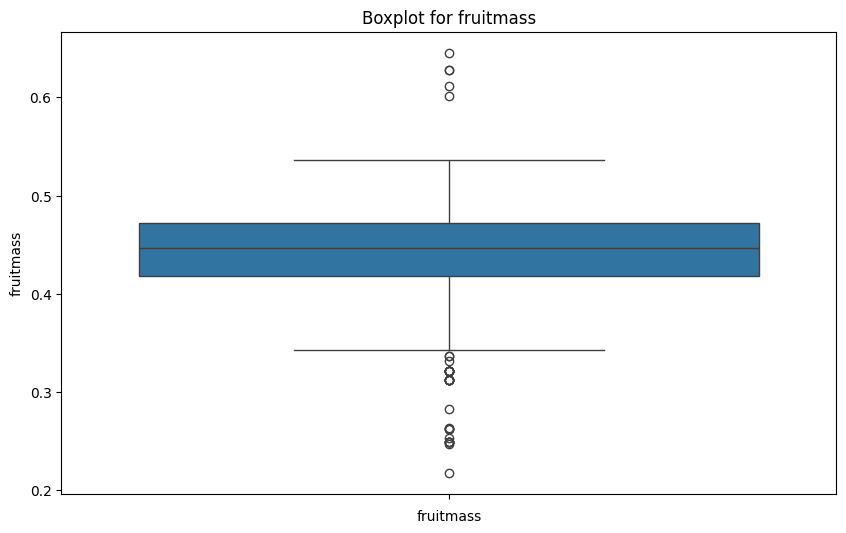

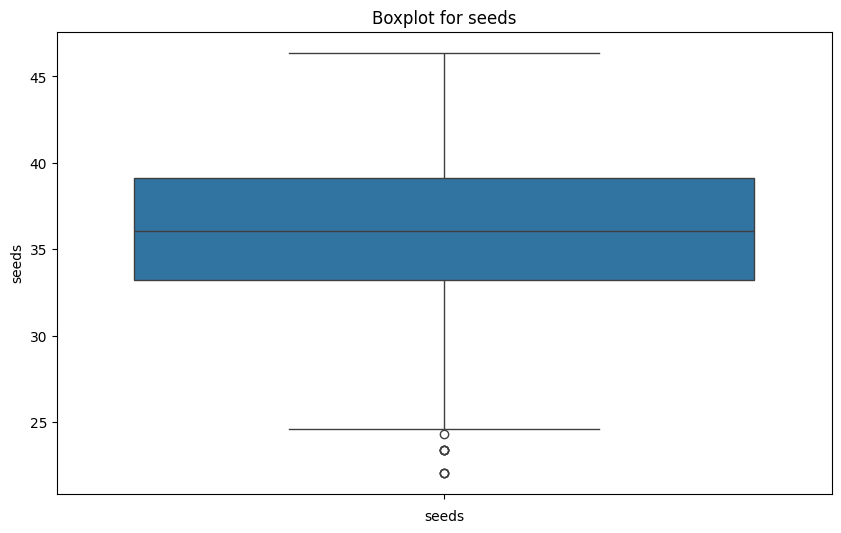

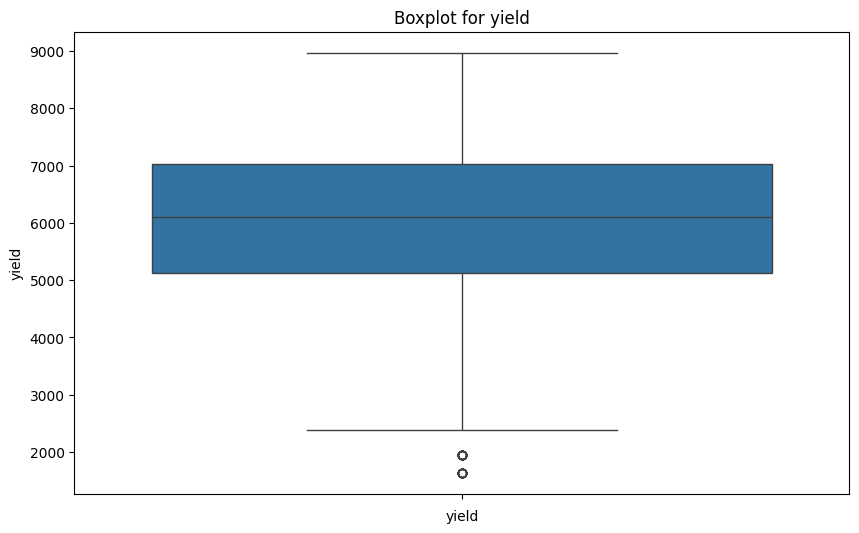

In [28]:
columns_to_check = train_df.columns  
for col in columns_to_check:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=train_df[col])
    plt.title(f"Boxplot for {col}")
    plt.xlabel(col)
    plt.show()

## Find the best parameters to RandomForestRegressor with Optuna

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae  
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=70)
print("Best parameters:", study.best_params)
print("Best MAE score:", study.best_value)
best_params = study.best_params
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print("Optimized Mean Absolute Error (MAE):", mae_best)
print("Optimized R-squared (R2):", r2_best)

[I 2024-11-11 14:38:59,618] A new study created in memory with name: no-name-1e2e08f3-1276-477d-a79c-a295c897101f
[I 2024-11-11 14:39:07,601] Trial 0 finished with value: 248.45445997856626 and parameters: {'n_estimators': 275, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 248.45445997856626.
[I 2024-11-11 14:39:10,416] Trial 1 finished with value: 242.71114913579052 and parameters: {'n_estimators': 150, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 242.71114913579052.
[I 2024-11-11 14:39:16,387] Trial 2 finished with value: 243.1249738457565 and parameters: {'n_estimators': 291, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 242.71114913579052.
[I 2024-11-11 14:39:22,921] Trial 3 finished with value: 247.32880510781675 and parameters: {'n_estimators': 241, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value:

Best parameters: {'n_estimators': 165, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}
Best MAE score: 242.31027212093673
Optimized Mean Absolute Error (MAE): 242.31027212093673
Optimized R-squared (R2): 0.9278969898728084


## RandomForestRegressor with best parameters

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=156,max_depth=8,min_samples_split=9,min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) with Random Forest:", mae)

Mean Absolute Error (MAE) with Random Forest: 242.33727258878676


## Comparison graph of original and predicted values

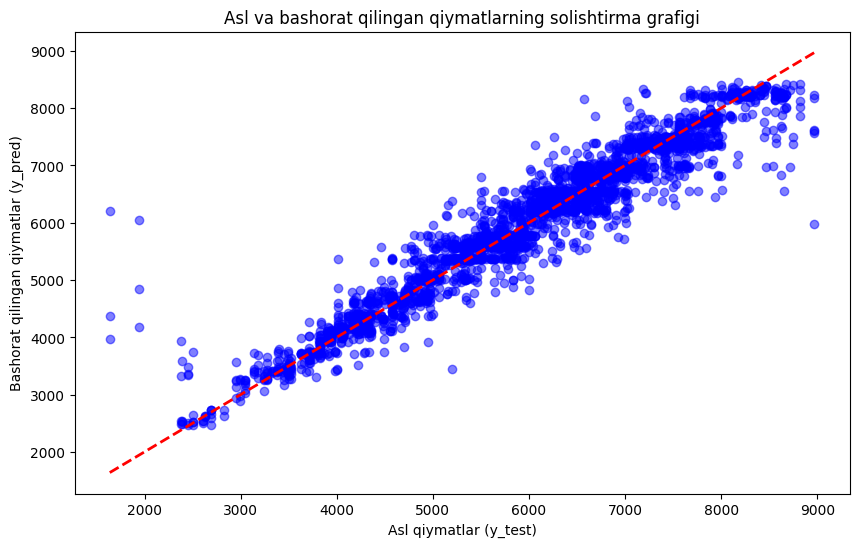

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.xlabel("Asl qiymatlar (y_test)")
plt.ylabel("Bashorat qilingan qiymatlar (y_pred)")
plt.title("Asl va bashorat qilingan qiymatlarning solishtirma grafigi")
plt.show()

## Correlation with target data

In [32]:
train_df.corr()[['yield']].style.background_gradient(cmap='coolwarm')

,yield
clonesize,-0.414196
honeybee,-0.107869
bumbles,0.177281
andrena,0.122463
osmia,0.271989
MaxOfUpperTRange,-0.004252
MinOfUpperTRange,-0.004008
AverageOfUpperTRange,-0.003666
MaxOfLowerTRange,-0.004082
MinOfLowerTRange,-0.004109


## clonesize

In [33]:
train_df.loc[train_df['clonesize'] == 40, 'clonesize'] = 37.5
train_df.loc[train_df['clonesize'] == 20, 'clonesize'] = 25
train_df.loc[train_df['clonesize'] == 10, 'clonesize'] = 12.5

## RainingDays

In [34]:
train_df.loc[train_df['RainingDays'] == 3.77, 'RainingDays'] = 16

## AverageRainingDays

In [35]:
train_df.loc[train_df['AverageRainingDays'] == 0.38, 'AverageRainingDays'] = 0.39

### RandomForestRegressor with best hyperparameters

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=163,max_depth=8,min_samples_split=7,min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) with Random Forest:", mae)

Mean Absolute Error (MAE) with Random Forest: 242.3353403859066


## Comparison graph of original and predicted values

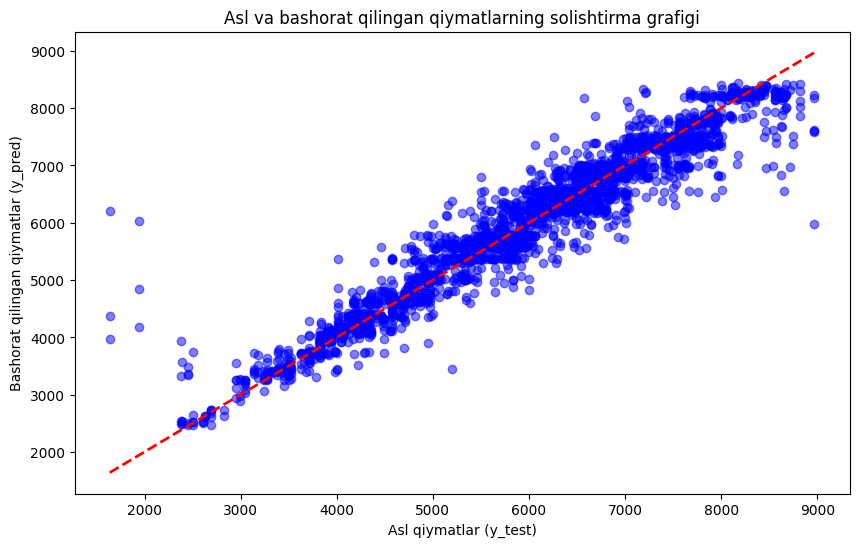

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.xlabel("Asl qiymatlar (y_test)")
plt.ylabel("Bashorat qilingan qiymatlar (y_pred)")
plt.title("Asl va bashorat qilingan qiymatlarning solishtirma grafigi")
plt.show()

## Using SHAP (SHapley Additive exPlanations)

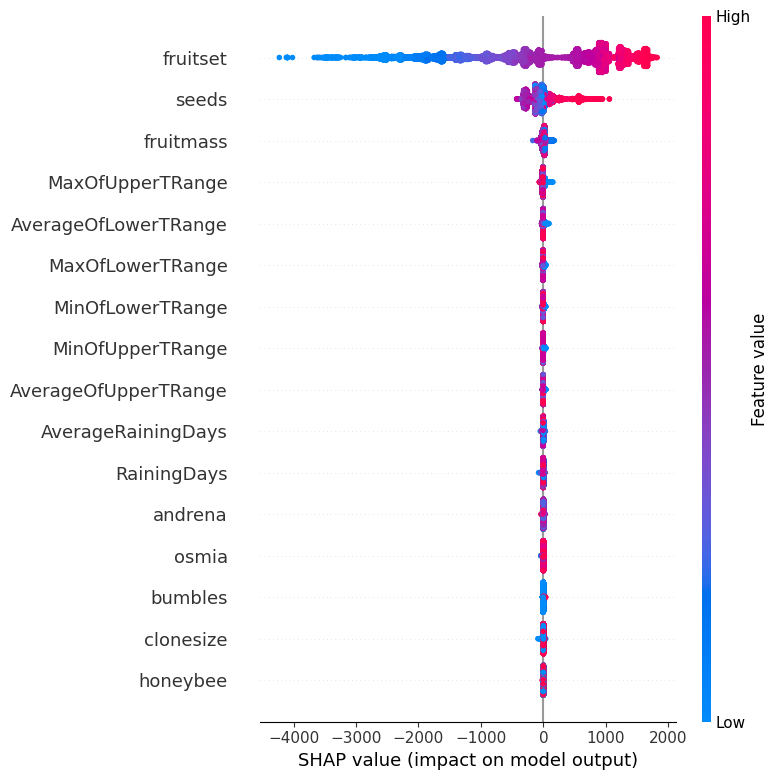

Mean Absolute Error (MAE) with Random Forest: 242.36919994335298


In [38]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train) 

mean_shap_values = np.abs(shap_values).mean(axis=0)
selected_features = X_train.columns[mean_shap_values > 0.01]  
X_train = X_train[selected_features]
X_test = X_test[selected_features]

model = RandomForestRegressor(n_estimators=128,max_depth=8,min_samples_split=4,min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) with Random Forest:", mae)

## Find the best parameters for RandomForestRegressor with Optuna

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae 

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=70)

print("Best parameters:", study.best_params)
print("Best MAE score:", study.best_value)

best_params = study.best_params
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Optimized Mean Absolute Error (MAE):", mae_best)
print("Optimized R-squared (R2):", r2_best)

[I 2024-11-11 14:43:43,225] A new study created in memory with name: no-name-76a2b65c-ee7d-4658-b735-e6b07d3b2809
[I 2024-11-11 14:43:47,722] Trial 0 finished with value: 249.74051079409756 and parameters: {'n_estimators': 145, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 249.74051079409756.
[I 2024-11-11 14:43:49,104] Trial 1 finished with value: 245.43380888521816 and parameters: {'n_estimators': 57, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 1 with value: 245.43380888521816.
[I 2024-11-11 14:43:52,450] Trial 2 finished with value: 244.23748480846695 and parameters: {'n_estimators': 152, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 244.23748480846695.
[I 2024-11-11 14:43:54,930] Trial 3 finished with value: 243.89138661303042 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 3 with value

Best parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6}
Best MAE score: 242.43975733018783
Optimized Mean Absolute Error (MAE): 242.43975733018783
Optimized R-squared (R2): 0.9278657395471331


## RandomForestRegressor with best parameters

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=55,max_depth=8,min_samples_split=4,min_samples_leaf=7, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) with Random Forest:", mae)

Mean Absolute Error (MAE) with Random Forest: 242.28887210885924


## Comparison graph of original and predicted values

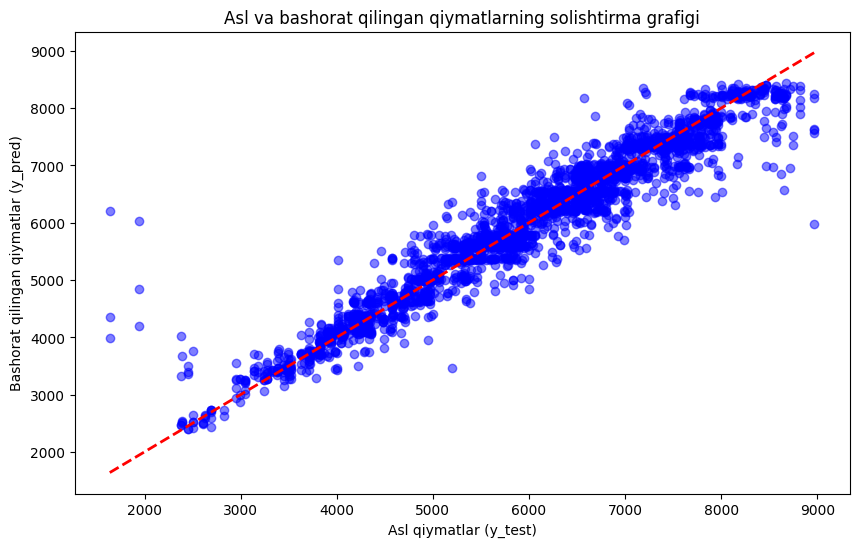

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.xlabel("Asl qiymatlar (y_test)")
plt.ylabel("Bashorat qilingan qiymatlar (y_pred)")
plt.title("Asl va bashorat qilingan qiymatlarning solishtirma grafigi")
plt.show()

## Feature Engeneering

In [42]:
# For train data
train_df['UpperTRangeDiff'] = train_df['MaxOfUpperTRange'] - train_df['MinOfUpperTRange']
train_df['LowerTRangeDiff'] = train_df['MaxOfLowerTRange'] - train_df['MinOfLowerTRange']
train_df['AverageTemp'] = (train_df['AverageOfUpperTRange'] + train_df['AverageOfLowerTRange']) / 2
train_df['Honeybee_Fruitset'] = train_df['honeybee'] * train_df['fruitset']
train_df['Bumbles_Fruitset'] = train_df['bumbles'] * train_df['fruitset']
train_df['Andrena_Fruitset'] = train_df['andrena'] * train_df['fruitset']
train_df['Osmia_Fruitset'] = train_df['osmia'] * train_df['fruitset']
train_df['RainingDays_Fruitmass'] = train_df['RainingDays'] * train_df['fruitmass']
train_df['AverageRaining_Fruitmass'] = train_df['AverageRainingDays'] * train_df['fruitmass']
train_df['CloneSize_Fruitmass'] = train_df['clonesize'] * train_df['fruitmass']
train_df['Seeds_Fruitmass'] = train_df['seeds'] * train_df['fruitmass']
train_df['CloneSize_Seeds'] = train_df['clonesize'] * train_df['seeds']
train_df['TotalBees'] = train_df['honeybee'] + train_df['bumbles'] + train_df['andrena'] + train_df['osmia']
# For test data
test_df['UpperTRangeDiff'] = test_df['MaxOfUpperTRange'] - test_df['MinOfUpperTRange']
test_df['LowerTRangeDiff'] = test_df['MaxOfLowerTRange'] - test_df['MinOfLowerTRange']
test_df['AverageTemp'] = (test_df['AverageOfUpperTRange'] + test_df['AverageOfLowerTRange']) / 2
test_df['Honeybee_Fruitset'] = test_df['honeybee'] * test_df['fruitset']
test_df['Bumbles_Fruitset'] = test_df['bumbles'] * test_df['fruitset']
test_df['Andrena_Fruitset'] = test_df['andrena'] * test_df['fruitset']
test_df['Osmia_Fruitset'] = test_df['osmia'] * test_df['fruitset']
test_df['RainingDays_Fruitmass'] = test_df['RainingDays'] * test_df['fruitmass']
test_df['AverageRaining_Fruitmass'] = test_df['AverageRainingDays'] * test_df['fruitmass']
test_df['CloneSize_Fruitmass'] = test_df['clonesize'] * test_df['fruitmass']
test_df['Seeds_Fruitmass'] = test_df['seeds'] * test_df['fruitmass']
test_df['CloneSize_Seeds'] = test_df['clonesize'] * test_df['seeds']
test_df['TotalBees'] = test_df['honeybee'] + test_df['bumbles'] + test_df['andrena'] + test_df['osmia']
# For train data
train_df['CloneSize_Honeybee_Ratio'] = train_df['clonesize'] / (train_df['honeybee'] + 1e-5)  # Nolga bo'linishdan qochish uchun kichik qiymat qo'shildi
train_df['CloneSize_Bumbles_Ratio'] = train_df['clonesize'] / (train_df['bumbles'] + 1e-5)
train_df['CloneSize_Andrena_Ratio'] = train_df['clonesize'] / (train_df['andrena'] + 1e-5)
train_df['CloneSize_Osmia_Ratio'] = train_df['clonesize'] / (train_df['osmia'] + 1e-5)
train_df['RainingDays_Fruitmass_Ratio'] = train_df['RainingDays'] / (train_df['fruitmass'] + 1e-5)
train_df['RainingDays_Fruitset_Ratio'] = train_df['RainingDays'] / (train_df['fruitset'] + 1e-5)
train_df['Honeybee_Fruitmass_Efficiency'] = train_df['honeybee'] * train_df['fruitmass']
train_df['Bumbles_Fruitmass_Efficiency'] = train_df['bumbles'] * train_df['fruitmass']
train_df['Andrena_Fruitmass_Efficiency'] = train_df['andrena'] * train_df['fruitmass']
train_df['Osmia_Fruitmass_Efficiency'] = train_df['osmia'] * train_df['fruitmass']
train_df['Honeybee_Fruitset_Efficiency'] = train_df['honeybee'] * train_df['fruitset']
train_df['Bumbles_Fruitset_Efficiency'] = train_df['bumbles'] * train_df['fruitset']
train_df['Andrena_Fruitset_Efficiency'] = train_df['andrena'] * train_df['fruitset']
train_df['Osmia_Fruitset_Efficiency'] = train_df['osmia'] * train_df['fruitset']
train_df['Seeds_Fruitmass_Ratio'] = train_df['seeds'] / (train_df['fruitmass'] + 1e-5)
# For test data
test_df['CloneSize_Honeybee_Ratio'] = test_df['clonesize'] / (test_df['honeybee'] + 1e-5) 
test_df['CloneSize_Bumbles_Ratio'] = test_df['clonesize'] / (test_df['bumbles'] + 1e-5)
test_df['CloneSize_Andrena_Ratio'] = test_df['clonesize'] / (test_df['andrena'] + 1e-5)
test_df['CloneSize_Osmia_Ratio'] = test_df['clonesize'] / (test_df['osmia'] + 1e-5)
test_df['RainingDays_Fruitmass_Ratio'] = test_df['RainingDays'] / (test_df['fruitmass'] + 1e-5)
test_df['RainingDays_Fruitset_Ratio'] = test_df['RainingDays'] / (test_df['fruitset'] + 1e-5)
test_df['Honeybee_Fruitmass_Efficiency'] = test_df['honeybee'] * test_df['fruitmass']
test_df['Bumbles_Fruitmass_Efficiency'] = test_df['bumbles'] * test_df['fruitmass']
test_df['Andrena_Fruitmass_Efficiency'] = test_df['andrena'] * test_df['fruitmass']
test_df['Osmia_Fruitmass_Efficiency'] = test_df['osmia'] * test_df['fruitmass']
test_df['Honeybee_Fruitset_Efficiency'] = test_df['honeybee'] * test_df['fruitset']
test_df['Bumbles_Fruitset_Efficiency'] = test_df['bumbles'] * test_df['fruitset']
test_df['Andrena_Fruitset_Efficiency'] = test_df['andrena'] * test_df['fruitset']
test_df['Osmia_Fruitset_Efficiency'] = test_df['osmia'] * test_df['fruitset']
test_df['Seeds_Fruitmass_Ratio'] = test_df['seeds'] / (test_df['fruitmass'] + 1e-5)
# For train data
train_df['Fruitset_RainRatio'] = train_df['fruitset'] / (train_df['RainingDays'] + 1e-5)
train_df['Fruitmass_RainRatio'] = train_df['fruitmass'] / (train_df['RainingDays'] + 1e-5)
train_df['RainSeasonality'] = train_df['RainingDays'] / (train_df['AverageRainingDays'] + 1e-5)
train_df['AverageUpperTemp_Fruitmass'] = train_df['AverageOfUpperTRange'] * train_df['fruitmass']
train_df['AverageLowerTemp_Fruitmass'] = train_df['AverageOfLowerTRange'] * train_df['fruitmass']
train_df['AverageUpperTemp_Fruitset'] = train_df['AverageOfUpperTRange'] * train_df['fruitset']
train_df['AverageLowerTemp_Fruitset'] = train_df['AverageOfLowerTRange'] * train_df['fruitset']
train_df['AverageUpperTemp_Seeds'] = train_df['AverageOfUpperTRange'] * train_df['seeds']
train_df['AverageLowerTemp_Seeds'] = train_df['AverageOfLowerTRange'] * train_df['seeds']
# For test data
test_df['Fruitset_RainRatio'] = test_df['fruitset'] / (test_df['RainingDays'] + 1e-5)
test_df['Fruitmass_RainRatio'] = test_df['fruitmass'] / (test_df['RainingDays'] + 1e-5)
test_df['RainSeasonality'] = test_df['RainingDays'] / (test_df['AverageRainingDays'] + 1e-5)
test_df['AverageUpperTemp_Fruitmass'] = test_df['AverageOfUpperTRange'] * test_df['fruitmass']
test_df['AverageLowerTemp_Fruitmass'] = test_df['AverageOfLowerTRange'] * test_df['fruitmass']
test_df['AverageUpperTemp_Fruitset'] = test_df['AverageOfUpperTRange'] * test_df['fruitset']
test_df['AverageLowerTemp_Fruitset'] = test_df['AverageOfLowerTRange'] * test_df['fruitset']
test_df['AverageUpperTemp_Seeds'] = test_df['AverageOfUpperTRange'] * test_df['seeds']
test_df['AverageLowerTemp_Seeds'] = test_df['AverageOfLowerTRange'] * test_df['seeds']
# For train data
train_df['CloneSize_UpperTemp_Ratio'] = train_df['clonesize'] / (train_df['AverageOfUpperTRange'] + 1e-5)
train_df['CloneSize_LowerTemp_Ratio'] = train_df['clonesize'] / (train_df['AverageOfLowerTRange'] + 1e-5)
train_df['CloneSize_RainingDays_Ratio'] = train_df['clonesize'] / (train_df['RainingDays'] + 1e-5)
train_df['Honeybee_Bumbles_Ratio'] = train_df['honeybee'] / (train_df['bumbles'] + 1e-5)
train_df['Andrena_Osmia_Ratio'] = train_df['andrena'] / (train_df['osmia'] + 1e-5)
train_df['TotalBee_Ratio'] = (train_df['honeybee'] + train_df['bumbles']) / (train_df['andrena'] + train_df['osmia'] + 1e-5)
train_df['Fruitmass_Seeds_Product'] = train_df['fruitmass'] * train_df['seeds']
train_df['Fruitmass_Seeds_Avg'] = (train_df['fruitmass'] + train_df['seeds']) / 2
train_df['Upper_Lower_Temp_Ratio'] = train_df['MaxOfUpperTRange'] / (train_df['MinOfLowerTRange'] + 1e-5)
train_df['Upper_Lower_Temp_Sum'] = train_df['MaxOfUpperTRange'] + train_df['MinOfLowerTRange']
# For test data
test_df['CloneSize_UpperTemp_Ratio'] = test_df['clonesize'] / (test_df['AverageOfUpperTRange'] + 1e-5)
test_df['CloneSize_LowerTemp_Ratio'] = test_df['clonesize'] / (test_df['AverageOfLowerTRange'] + 1e-5)
test_df['CloneSize_RainingDays_Ratio'] = test_df['clonesize'] / (test_df['RainingDays'] + 1e-5)
test_df['Honeybee_Bumbles_Ratio'] = test_df['honeybee'] / (test_df['bumbles'] + 1e-5)
test_df['Andrena_Osmia_Ratio'] = test_df['andrena'] / (test_df['osmia'] + 1e-5)
test_df['TotalBee_Ratio'] = (test_df['honeybee'] + test_df['bumbles']) / (test_df['andrena'] + test_df['osmia'] + 1e-5)
test_df['Fruitmass_Seeds_Product'] = test_df['fruitmass'] * test_df['seeds']
test_df['Fruitmass_Seeds_Avg'] = (test_df['fruitmass'] + test_df['seeds']) / 2
test_df['Upper_Lower_Temp_Ratio'] = test_df['MaxOfUpperTRange'] / (test_df['MinOfLowerTRange'] + 1e-5)
test_df['Upper_Lower_Temp_Sum'] = test_df['MaxOfUpperTRange'] + test_df['MinOfLowerTRange']

## RFE

In [43]:
X=train_df.drop(columns=['yield'],axis=1)
y=train_df['yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_model = RandomForestRegressor(n_estimators=128, max_depth=8, min_samples_split=4, min_samples_leaf=5, random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=10, step=1)  
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Tanlangan xususiyatlar:", selected_features)
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]
model = RandomForestRegressor(n_estimators=128, max_depth=8, min_samples_split=4, min_samples_leaf=5, random_state=42)
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) with RFE and Random Forest:", mae)
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) with RFE and Random Forest:", r2)

Tanlangan xususiyatlar: Index(['fruitset', 'seeds', 'RainingDays_Fruitmass', 'Seeds_Fruitmass',
       'Bumbles_Fruitset_Efficiency', 'AverageLowerTemp_Fruitmass',
       'AverageLowerTemp_Fruitset', 'AverageUpperTemp_Seeds',
       'Fruitmass_Seeds_Product', 'Fruitmass_Seeds_Avg'],
      dtype='object')
Mean Absolute Error (MAE) with RFE and Random Forest: 244.50161579719384
R-squared (R2) with RFE and Random Forest: 0.9273064788638653


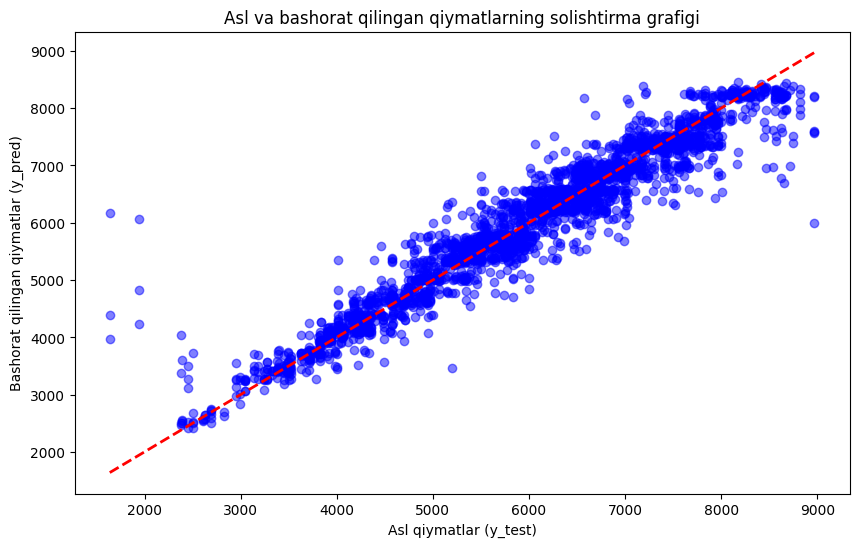

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.xlabel("Asl qiymatlar (y_test)")
plt.ylabel("Bashorat qilingan qiymatlar (y_pred)")
plt.title("Asl va bashorat qilingan qiymatlarning solishtirma grafigi")
plt.show()

## Recursive Feature Elimination RFE

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=128,max_depth=8,min_samples_split=4,min_samples_leaf=5, random_state=42)
rfe = RFE(model, n_features_to_select=10)  
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
X_train = X_train[selected_features]
X_test = X_test[selected_features]


model = RandomForestRegressor(n_estimators=128, max_depth=8, min_samples_split=4, min_samples_leaf=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) with RFE-selected features:", mae)

Mean Absolute Error (MAE) with RFE-selected features: 244.50161579719384


## Correlation after Feature Engeneering

In [46]:
train_df.corr()[['yield']].style.background_gradient(cmap='coolwarm')

,yield
clonesize,-0.415877
honeybee,-0.107869
bumbles,0.177281
andrena,0.122463
osmia,0.271989
MaxOfUpperTRange,-0.004252
MinOfUpperTRange,-0.004008
AverageOfUpperTRange,-0.003666
MaxOfLowerTRange,-0.004082
MinOfLowerTRange,-0.004109


In [47]:
new_df=train_df[['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'RainingDays_Fruitmass','Seeds_Fruitmass','Bumbles_Fruitset_Efficiency',
       'AverageLowerTemp_Fruitmass','AverageLowerTemp_Fruitset','AverageUpperTemp_Seeds',
       'Fruitmass_Seeds_Product','Fruitmass_Seeds_Avg','yield']]

In [48]:
new_test_df=test_df[['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'RainingDays_Fruitmass','Seeds_Fruitmass','Bumbles_Fruitset_Efficiency',
       'AverageLowerTemp_Fruitmass','AverageLowerTemp_Fruitset','AverageUpperTemp_Seeds',
       'Fruitmass_Seeds_Product','Fruitmass_Seeds_Avg']]

In [ ]:
X=new_df.drop(columns=['yield'], axis=1)
y=new_df['yield']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('bagging', BaggingRegressor(
        estimator=RandomForestRegressor(
            n_estimators=160, 
            max_depth=8, 
            min_samples_split=6, 
            min_samples_leaf=5, 
            random_state=42
        ),
        n_estimators=10,
        random_state=42
    ))
])
cv_mae_scores = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Cross-Validation MAE Scores:", cv_mae_scores)
print("Mean Bagging Cross-Validation MAE:", cv_mae_scores.mean())
print("Standard Deviation of Bagging MAE:", cv_mae_scores.std())
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE) with Pipeline Bagging Random Forest:", mae)

Cross-Validation MAE Scores: [248.09687767 245.2883136  246.74157828 244.43174163 252.72382801]
Mean Bagging Cross-Validation MAE: 247.45646784036822
Standard Deviation of Bagging MAE: 2.916029370070478
Mean Absolute Error (MAE) with Pipeline Bagging Random Forest: 242.81654987218587


Best Random Forest MAE: 242.5561659170636
Decision Tree MAE: 366.32776979
KNN MAE: 344.310711982


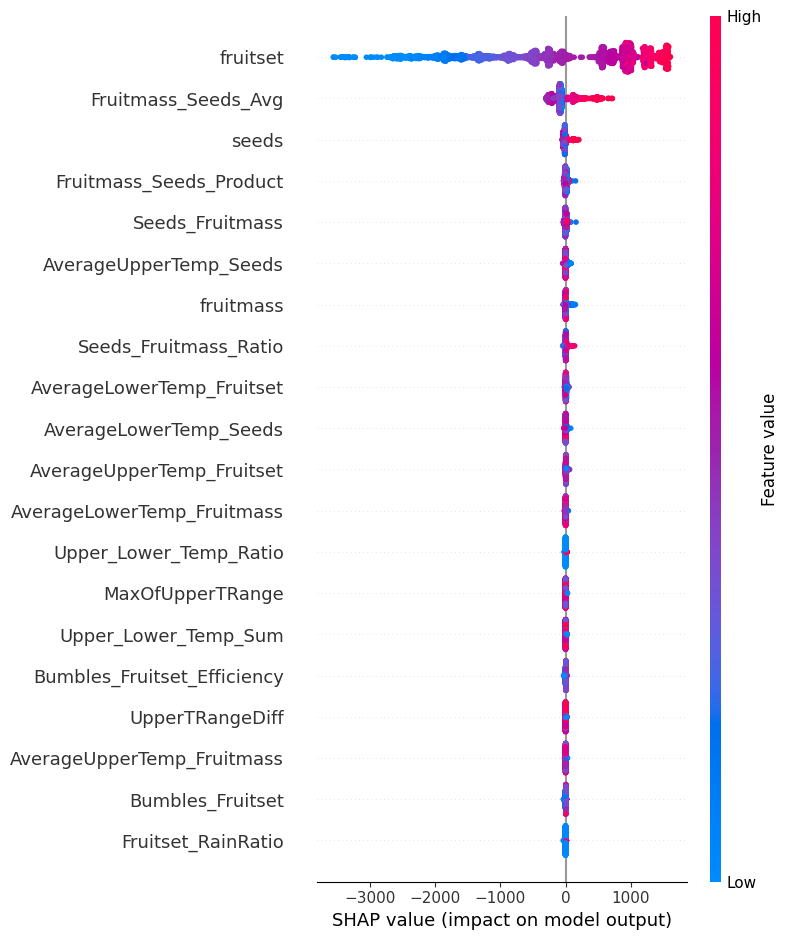

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Random Forest with hyperparameter tuning
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 160, 200],
    'max_depth': [6, 8, 10],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [3, 5, 7]
}
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)
# Get best model and predict
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("Best Random Forest MAE:", mae_rf)
# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
print("Decision Tree MAE:", mae_dt)
# K-Nearest Neighbors Regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print("KNN MAE:", mae_knn)
explainer_shap = shap.TreeExplainer(best_rf)
shap_values = explainer_shap.shap_values(X_test)
shap.summary_plot(shap_values, X_test)  
# LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['yield'], mode='regression')
i = 0  
exp = explainer_lime.explain_instance(X_test.values[i], best_rf.predict, num_features=10)
exp.show_in_notebook(show_table=True)

In [51]:
X = new_df.drop(columns=['yield'])  
y = new_df['yield'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
   
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae  
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=70)
print("Best parameters:", study.best_params)
print("Best MAE score:", study.best_value)
best_params = study.best_params
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Optimized Mean Absolute Error (MAE):", mae_best)
print("Optimized R-squared (R2):", r2_best)

[I 2024-11-11 15:35:24,206] A new study created in memory with name: no-name-a9d75f0c-7079-412d-b4a8-2d108225d19f
[I 2024-11-11 15:35:26,418] Trial 0 finished with value: 245.491724771783 and parameters: {'n_estimators': 59, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 0 with value: 245.491724771783.
[I 2024-11-11 15:35:37,543] Trial 1 finished with value: 243.72870078113186 and parameters: {'n_estimators': 241, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 243.72870078113186.
[I 2024-11-11 15:35:50,364] Trial 2 finished with value: 243.6047687564836 and parameters: {'n_estimators': 254, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 2 with value: 243.6047687564836.
[I 2024-11-11 15:35:54,959] Trial 3 finished with value: 248.7382130583139 and parameters: {'n_estimators': 66, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 243.60476

Best parameters: {'n_estimators': 237, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9}
Best MAE score: 243.4005296533731
Optimized Mean Absolute Error (MAE): 243.4005296533731
Optimized R-squared (R2): 0.927680162091291


In [52]:
y_pred_best = best_model.predict(new_test_df)


In [53]:
df=pd.read_csv('sample_submission.csv')
df['yield']=y_pred_best
df

,id,yield
0,15000,5473.091599
1,15001,6594.598576
2,15002,4643.244207
3,15003,6245.391412
4,15004,7019.996267
...,...,...
9995,24995,4655.815141
9996,24996,5492.278103
9997,24997,6077.872033
9998,24998,5564.808743


In [ ]:
df.to_csv('submission-1.csv', index=False)